In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np 
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.dates as dates

np.warnings.filterwarnings('ignore')
import os
import datetime

from split_filename import *
from nigthshade import *
from GOLD import *

class GOLD:
    
    def __init__(self, filename, infile = None):
        
        self.infile = infile 
        self.filename = filename
    
        if isinstance(filename, xr.Dataset):
            self.dataset = filename 
        else:
            self.dataset = xr.open_dataset(self.infile + self.filename)
            file_args = split_filename(self.filename)
        
            if file_args.product == 'LIM':
                self.dims = ['n_lat', 'n_alt']

                self.dataset.coords['n_alt'] = self.dataset['GRID_ALT'].values
                self.dataset.coords['n_lat'] = self.dataset['GRID_LAT'].values
                
                self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].mean(dim = self.dims)

            elif file_args.product == 'OCC':

                self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].values[0]
                self.dataset.coords['nTimes'] = bytes_string(self.dataset['TIME_UTC'])
                

            else:
                self.dims = ['n_ns', 'n_ew']

                self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].mean(dim = self.dims)
    
    def dataset(self):
        return self.dataset
        
    
    def get_1356(self):
        """
        1356 brightness map (in Rayleighs) integrates the signal from 133 to 137 nm
        """
        arr = self.dataset['n_wavelength'].values
        
        cond = (arr > 133) & (arr < 137)
        
        result_1356 = np.where(cond, arr, np.nan)
        
        result_1356 = result_1356[~np.isnan(result_1356)]

        return self.dataset.sel(n_wavelength = result_1356)

    
    def get_LBH(self, band = 'total'):
        """
        Individual files:
            Total LBH brightness map (in Rayleighs) integrates the signal from 137 to 155 nm
            with 148.5 to 150.0 nm masked;
        Combined files:
            LBH band 1 brightness map (in Rayleighs) integrates the signal from 140 to 148 nm; 
            LBH band 2 brightness map (in Rayleighs) integrates the signal from 150 to 160 nm. 
        """
        wavelength_values = self.dataset['n_wavelength'].values
        
        if band == 'total':
            start, end = 137, 155
        elif band == 1:
            start, end = 140, 148
        else:
            start, end = 150, 160
        
        cond = (wavelength_values > start) & (wavelength_values < end)
        
        result_LHB = np.where(cond, wavelength_values, np.nan)
        
        result_LHB = result_LHB[~np.isnan(result_LHB)]

        return self.dataset.sel(n_wavelength = result_LHB)
    

In [3]:
infile = 'C:\\Users\\Luiz Felipe\\Downloads\\LIM2019111120191112\\tmp\\archive_L1C\\2019\\315\\' 

_, _, files = next(os.walk(infile))

combined = []

for i in range(len(files) - 1):
    
    combined.append([files[i], files[i + 1]])
    

combined = combined[::2]


In [4]:
datasets = []

for i in range(len(combined)):
    filename = combined[i]

    n = GOLD(filename[0], infile).dataset
    s = GOLD(filename[1], infile).dataset

    datasets.append(n.combine_first(s))

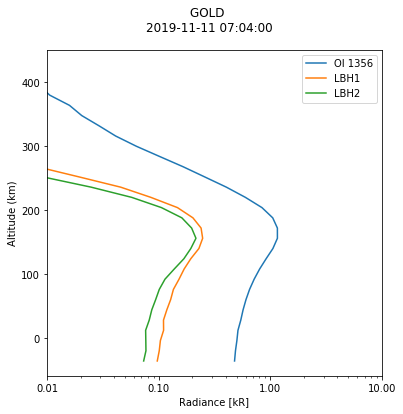

In [31]:
ds = GOLD(datasets[0])

ds1 = ds.get_1356().mean(dim = ['n_lat', 'n_wavelength'], skipna = True)
ds2 = ds.get_LBH(band = 1).mean(dim = ['n_lat', 'n_wavelength'], skipna = True)
ds3 = ds.get_LBH(band = 2).mean(dim = ['n_lat', 'n_wavelength'], skipna = True)

oi135 = ds1['RADIANCE'].values / 1000
lbh1 = ds2['RADIANCE'].values / 1000
lbh2 = ds3['RADIANCE'].values/ 1000
alts = ds1['n_alt'].values


fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(oi135, alts, label = 'OI 1356')
ax.plot(lbh1, alts, label = 'LBH1')
ax.plot(lbh2, alts, label = 'LBH2')

ax.set(xscale = 'log', xlim = [0.01, 10], 
       xlabel = 'Radiance [kR]', ylabel = 'Altitude (km)')

ax.legend()

from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())


fig.suptitle("GOLD \n" + str(split_filename(files[0]).datetime))
plt.show()

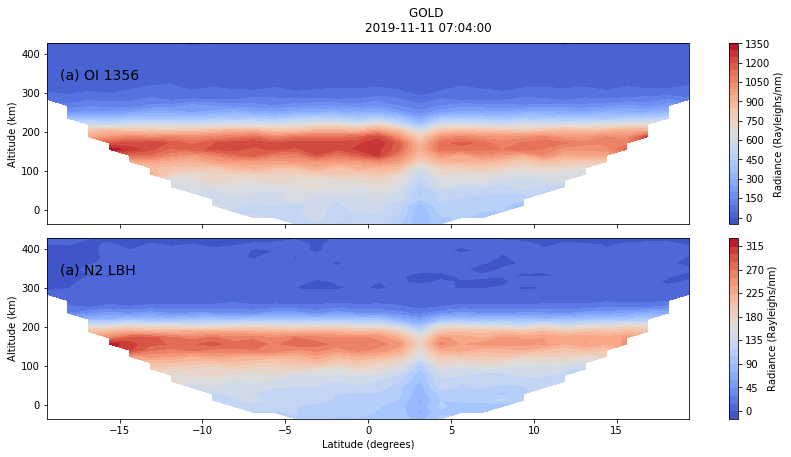

In [269]:
fig, ax = plt.subplots(figsize = (12, 6), nrows = 2, sharex = True, sharey = True)

ds = GOLD(datasets[0])

ds1 = ds.get_1356().mean(dim = 'n_wavelength', skipna = True)

alts = ds1['n_alt'].values
lats = ds1['n_lat'].values
data = ds1['RADIANCE'].values.T

img = ax[0].contourf(lats, alts, data, 30, cmap = 'coolwarm')

cb = fig.colorbar(img,  ax = ax[0])
cb.set_label(f"{NAME} ({UNIT})")


ax[0].set(ylabel = 'Altitude (km)')
ax[0].text(0.02, 0.8,  "(a) OI 1356", fontsize = 14, transform = ax[0].transAxes)

ds2 = ds.get_LBH().mean(dim = 'n_wavelength', skipna = True)

alts = ds2['n_alt'].values
lats = ds2['n_lat'].values
data = ds2['RADIANCE'].values.T

img = ax[1].contourf(lats, alts, data, 30, cmap = 'coolwarm')

cb = fig.colorbar(img, ax = ax[1])
cb.set_label(f"{NAME} ({UNIT})")


ax[1].set(ylabel = 'Altitude (km)', xlabel = 'Latitude (degrees)')
ax[1].text(0.02, 0.8,  "(a) N2 LBH", fontsize = 14, transform = ax[1].transAxes)

fig.suptitle("GOLD \n" + str(split_filename(files[0]).datetime), y = 1.05)
plt.tight_layout()
plt.show()

In [99]:
Naltitudes1356 = []
Nlatitudes1356 = []

NaltitudesLBH = []
NlatitudesLBH = []

Saltitudes1356 = []
Slatitudes1356 = []

SaltitudesLBH = []
SlatitudesLBH = []

Ntimes = []
Stimes = []

for i in range(len(files)):
    a = GOLD(files[i], infile)

    parameter = 'RADIANCE'

    mirror = a.dataset.attrs['MIRROR_HEMISPHERE']
    
    data1356_alt = a.get_1356().mean(dim = ['n_lat', 'n_wavelength'], skipna = True)[parameter].values

    data1356_lat = a.get_1356().mean(dim = ['n_alt', 'n_wavelength'], skipna = True)[parameter].values

    dataLBH_alt = a.get_LBH().mean(dim = ['n_lat', 'n_wavelength'], skipna = True)[parameter].values

    dataLBH_lat = a.get_LBH().mean(dim = ['n_alt', 'n_wavelength'], skipna = True)[parameter].values
    
    if mirror == 'N':
        Naltitudes1356.append(data1356_alt)
        Nlatitudes1356.append(data1356_lat)
        NaltitudesLBH.append(dataLBH_alt)
        NlatitudesLBH.append(dataLBH_lat)
        Ntimes.append(split_filename(files[i]).datetime)
    else:
        Saltitudes1356.append(data1356_alt)
        Slatitudes1356.append(data1356_lat)
        SaltitudesLBH.append(dataLBH_alt)
        SlatitudesLBH.append(dataLBH_lat)
        Stimes.append(split_filename(files[i]).datetime)



In [182]:
data = np.vstack(Naltitudes1356).T



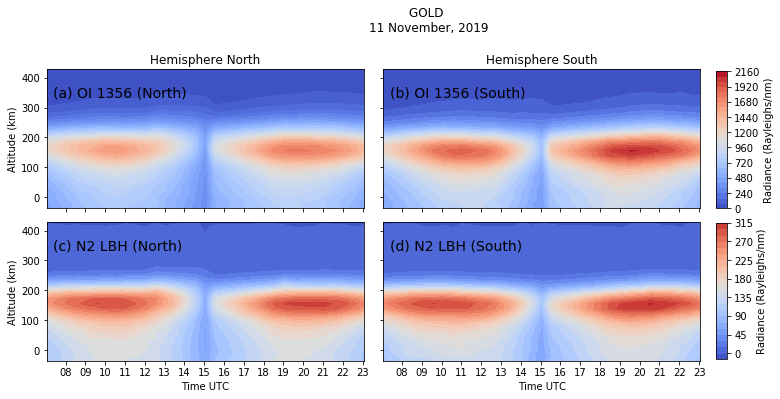

In [238]:
atributes = a.dataset['RADIANCE'].attrs

NAME = atributes['CATDESC']
UNIT = atributes['UNITS']


alts = a.dataset['n_alt'].values
lats = a.dataset['n_lat'].values

fig, ax = plt.subplots(figsize = (10, 5), nrows = 2, ncols = 2, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)

data_n = np.vstack(Naltitudes1356).T
data_s = np.vstack(Saltitudes1356).T

img = ax[0, 0].contourf(times, alts, data_n, 30, vmax = data_s.max(),cmap = 'coolwarm')

img = ax[0, 1].contourf(times, alts, data_s, 30, cmap = 'coolwarm')

ax[0,0].set(title = "Hemisphere North", ylabel = 'Altitude (km)')
ax[0,1].set(title = "Hemisphere South")

cbar_ax = fig.add_axes([1., 0.54, 0.015, 0.38])

cb = fig.colorbar(img, cax = cbar_ax, ax = ax[0, 1])

cb.set_label(f"{NAME} ({UNIT})")


data_n = np.vstack(NaltitudesLBH).T
data_s = np.vstack(SaltitudesLBH).T

img = ax[1, 1].contourf(times, alts, data_s,  30,  cmap = 'coolwarm')

img = ax[1, 0].contourf(times, alts, data_n,  30, vmax = data_s.max(), cmap = 'coolwarm')

cbar_ax = fig.add_axes([1., 0.12, 0.015, 0.38])

cb = fig.colorbar(img, cax = cbar_ax, ax = ax[1, 1])


cb.set_label(f"{NAME} ({UNIT})")

ax[1, 0].set(ylabel = 'Altitude (km)', xlabel = 'Time UTC')
ax[1, 1].set(xlabel = 'Time UTC')

ax[1, 0].xaxis.set_major_formatter(dates.DateFormatter('%H'))
ax[1, 0].xaxis.set_major_locator(dates.HourLocator(interval = 1))

ax[0, 0].text(0.02, 0.8,  "(a) OI 1356 (North)", fontsize = 14, transform = ax[0,0].transAxes)
ax[0, 1].text(0.02, 0.8,  "(b) OI 1356 (South)", fontsize = 14, transform = ax[0,1].transAxes)

ax[1, 0].text(0.02, 0.8,  "(c) N2 LBH (North)", fontsize = 14, transform = ax[1,0].transAxes)
ax[1, 1].text(0.02, 0.8,  "(d) N2 LBH (South)", fontsize = 14, transform = ax[1,1].transAxes)


fig.suptitle("GOLD \n" + split_filename(files[0]).date(), y = 1.1, x = 0.6)
plt.tight_layout()
plt.show()

In [36]:
def figure_name(files, emission):
    
    emission = emission.replace(' ', '_')
    
    if isinstance(files, list):
        
        if len(files) == 2:
            first, second = files[0], files[1]
        else:
            first, second = files[0], files[-1]
            
        start = split_filename(first)
        end = split_filename(second)
        time_start, time_end = start.time().replace(':',''), end.time().replace(':','')
        date = str(start.date(extent = False)).replace('-', '_')
        
        return f"GOLD_{start.product}_{emission}_{date}_{time_start}_{time_end}"
    else:
        start = split_filename(filename)
        if start.level == 'L2':
            emission = emission.upper()
            return f"GOLD_{emission.upper()}_{start.level}_{str(start.date(extent = False)).replace('-', '_')}"
        


FigureName = figure_name(files, 'RADIANCE')

FigureName

'GOLD_LIM_RADIANCE_2019_11_11_0704_2307'

In [37]:
PathOut = 'C:\\Users\\Luiz Felipe\\Google Drive\\Doutorado\\Modelos_Latex_INPE\\Figuras1\\'
fig.savefig(PathOut + FigureName + '.png', dpi = 100, quality = 95, bbox_inches="tight")
